# Hands-on explore GOES data

**Author**: Adriano P. Almeida adriano.almeida@inpe.br

**Avaiable at**: https://github.com/AdrianoPereira/py4goes

## Import libraries

In [5]:
import numpy as np
from osgeo import osr
from osgeo import gdal
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import colorsys
import cartopy, cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from scipy.ndimage.filters import gaussian_filter
import os

In [3]:
rcParams["figure.facecolor"] = '#FFFFFF'
rcParams["savefig.facecolor"] = '#FFFFFF'

In [16]:
!ls output_data/data/noaa-goes16/GLM-L2-LCFA/2024/073/00

OR_GLM-L2-LCFA_G16_s20240730000000_e20240730000200_c20240730000217.nc
OR_GLM-L2-LCFA_G16_s20240730000200_e20240730000400_c20240730000420.nc
OR_GLM-L2-LCFA_G16_s20240730000400_e20240730001000_c20240730001022.nc
OR_GLM-L2-LCFA_G16_s20240730001000_e20240730001200_c20240730001219.nc
OR_GLM-L2-LCFA_G16_s20240730001200_e20240730001400_c20240730001421.nc
OR_GLM-L2-LCFA_G16_s20240730001400_e20240730002000_c20240730002018.nc
OR_GLM-L2-LCFA_G16_s20240730002000_e20240730002200_c20240730002220.nc
OR_GLM-L2-LCFA_G16_s20240730002200_e20240730002400_c20240730002421.nc
OR_GLM-L2-LCFA_G16_s20240730002400_e20240730003000_c20240730003018.nc
OR_GLM-L2-LCFA_G16_s20240730003000_e20240730003200_c20240730003218.nc
OR_GLM-L2-LCFA_G16_s20240730003200_e20240730003400_c20240730003423.nc
OR_GLM-L2-LCFA_G16_s20240730003400_e20240730004000_c20240730004021.nc
OR_GLM-L2-LCFA_G16_s20240730004000_e20240730004200_c20240730004222.nc
OR_GLM-L2-LCFA_G16_s20240730004200_e20240730004400_c20240730004421.nc
OR_GLM-L2-LCFA_G16_s

In [17]:
file_paths = "/home/edith/py4goes"
out_path = f"{file_paths}/outputs/"
cpt_fn = f"{file_paths}/data/colorbar/IR4AVHRR6.cpt"
glm_fn = f"{file_paths}/notebooks/output_data/data/noaa-goes16/GLM-L2-LCFA/2024/073/00/OR_GLM-L2-LCFA_G16_s20240730000000_e20240730000200_c20240730000217.nc"
abi_fn = f"{file_paths}/notebooks/output_data/data/noaa-goes16/ABI-L2-CMIPF/2024/073/00/OR_ABI-L2-CMIPF-M6C13_G16_s20240730000205_e20240730009525_c20240730009589.nc"
shp_fn = f"{file_paths}/data/geo/south_america/south_america.shp"

# checking if files exist
if os.path.exists(cpt_fn):
    print(f"{cpt_fn} exists")
else:
    print(f"{cpt_fn} does not exists")

if os.path.exists(glm_fn):
    print(f"{glm_fn} exists")
else:
    print(f"{glm_fn} does not exists")

if os.path.exists(abi_fn):
    print(f"{abi_fn} exists")
else:
    print(f"{abi_fn} does not exists")


if os.path.exists(shp_fn):
    print(f"{shp_fn} exists")
else:
    print(f"{shp_fn} does not exists")



/home/edith/py4goes/data/colorbar/IR4AVHRR6.cpt exists
/home/edith/py4goes/notebooks/output_data/data/noaa-goes16/GLM-L2-LCFA/2024/073/00/OR_GLM-L2-LCFA_G16_s20240730000000_e20240730000200_c20240730000217.nc exists
/home/edith/py4goes/notebooks/output_data/data/noaa-goes16/ABI-L2-CMIPF/2024/073/00/OR_ABI-L2-CMIPF-M6C13_G16_s20240730000205_e20240730009525_c20240730009589.nc exists
/home/edith/py4goes/data/geo/south_america/south_america.shp exists


In [18]:
abi_ds = gdal.Open(f"NETCDF:{abi_fn}:CMI")
dqf_ds = gdal.Open(f"NETCDF:{abi_fn}:DQF")

ERROR 1: Unhandled X/Y axis unit rad. SRS will ignore axis unit and be likely wrong.
ERROR 1: Unhandled X/Y axis unit rad. SRS will ignore axis unit and be likely wrong.


In [19]:
# Get metadata
metadata = abi_ds.GetMetadata()
scale_factor = np.float32(metadata.get(f"CMI#scale_factor"))
offset = np.float32(metadata.get(f"CMI#add_offset"))
fill_value = np.float32(metadata.get(f"CMI#_FillValue"))
datetime = metadata.get('NC_GLOBAL#time_coverage_start')
datetime_fmt = (dt.datetime.strptime(datetime, '%Y-%m-%dT%H:%M:%S.%fZ'))


title_prod = metadata['NC_GLOBAL#title']
title_scene = metadata['NC_GLOBAL#scene_id']
geos_proj = abi_ds.GetProjectionRef()
lonlat_proj = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
geo_transform = abi_ds.GetGeoTransform()

# South America coordinates
lon_min, lat_min, lon_max, lat_max = -96, -30, -56, 24
target_proj_extent = lon_min, lat_max, lat_min, lon_max
img_extent = lon_min, lat_min, lon_max, lat_max

source_prj = osr.SpatialReference()
target_prj = osr.SpatialReference()
_ = source_prj.ImportFromProj4(geos_proj)
_ = target_prj.ImportFromProj4(lonlat_proj)

crop_transform_params = {
    'format': 'MEM',
    'srcSRS': source_prj,
    'dstSRS': target_prj,
    'outputBounds': target_proj_extent,
    'outputBoundsSRS': target_prj,
    'outputType': gdal.GDT_Float32,
    'srcNodata': fill_value,
    'dstNodata': 'nan',
    'resampleAlg': gdal.GRA_NearestNeighbour
}

satellite_height = 35786023.438 
central_longitude = -75.0
satellite_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
satellite_nrows, satellite_ncols = abi_ds.RasterYSize, abi_ds.RasterXSize
km_per_deg = 111.32
res_pixel_in_km = 2
res_x_in_km = int(((lon_max-lon_min)*km_per_deg)/res_pixel_in_km)
res_y_in_km = int(((lat_max-lat_min)*km_per_deg)/res_pixel_in_km)
res_x = (lon_max-lon_min)/satellite_ncols
res_y = (lat_max-lat_min)/satellite_nrows
ccrs_latlon_proj = ccrs.PlateCarree()
ccrs_geos_proj = ccrs.Geostationary(central_longitude=central_longitude, satellite_height=satellite_height)
geo_transform = abi_ds.GetGeoTransform()
crop_scene_name = "South America"

In [21]:
abi_data = abi_ds.ReadAsArray(0, 0, satellite_ncols, satellite_nrows).astype(np.float16)
dqf_data = dqf_ds.ReadAsArray(0, 0, dqf_ds.RasterXSize, dqf_ds.RasterYSize).astype(np.float16)

abi_data = np.where(abi_data == fill_value, np.nan, abi_data)
abi_data = abi_data*scale_factor+offset
abi_data = np.where(dqf_data > 0, np.nan, abi_data)

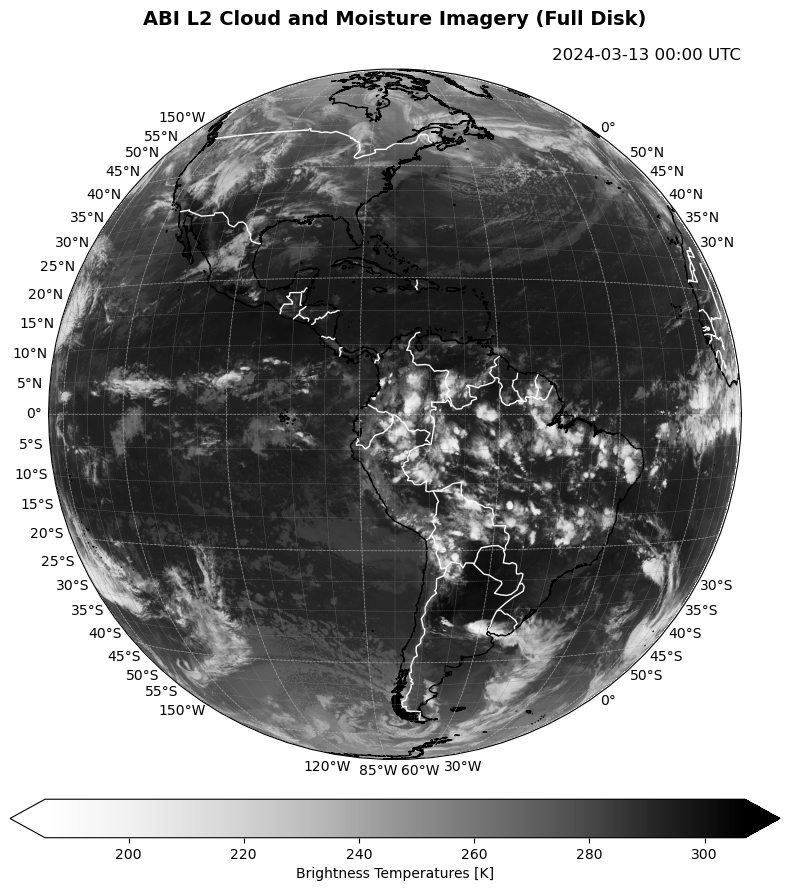

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs_geos_proj})


ax.set_title(f"{title_prod} ({title_scene})", loc='center', y=1.05, fontsize=14, fontweight='bold')
ax.set_title(f"{datetime_fmt.strftime('%Y-%m-%d %H:%M')} UTC", loc='right', fontsize=12)

img = ax.imshow(abi_data, origin='upper', extent=satellite_extent, cmap='Greys')
ax.coastlines(resolution='10m', color='k', linewidth=1)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=1)
ax.gridlines(color='white', alpha=0.5, linestyle='--', linewidth=0.5)


gl = ax.gridlines(crs=ccrs_latlon_proj, color='gray', alpha=1.0, linestyle='--', 
                  linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), 
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.colorbar(img, label='Brightness Temperatures [K]', 
             extend='both', orientation='horizontal', 
             pad=0.05, fraction=0.05)
plt.savefig(f"{out_path}/Full_Disk_{title_prod.replace(' ', '_')}_{datetime}.png",
           transparent=False, bbox_inches='tight', pad_inches=0.1)

In [23]:
driver = gdal.GetDriverByName('MEM')

extent = [lon_min, lon_max, lat_min, lat_max]

handle = driver.Create('raw', satellite_nrows, satellite_ncols, 1, gdal.GDT_Float32)
handle.SetGeoTransform(geo_transform)
handle.GetRasterBand(1).WriteArray(abi_data)


crop_abi_data = gdal.Warp('', handle, **crop_transform_params)
crop_abi_data = crop_abi_data.GetRasterBand(1).ReadAsArray()[::-1, :]

In [24]:
shp_geoms = list(shpreader.Reader(shp_fn).geometries())

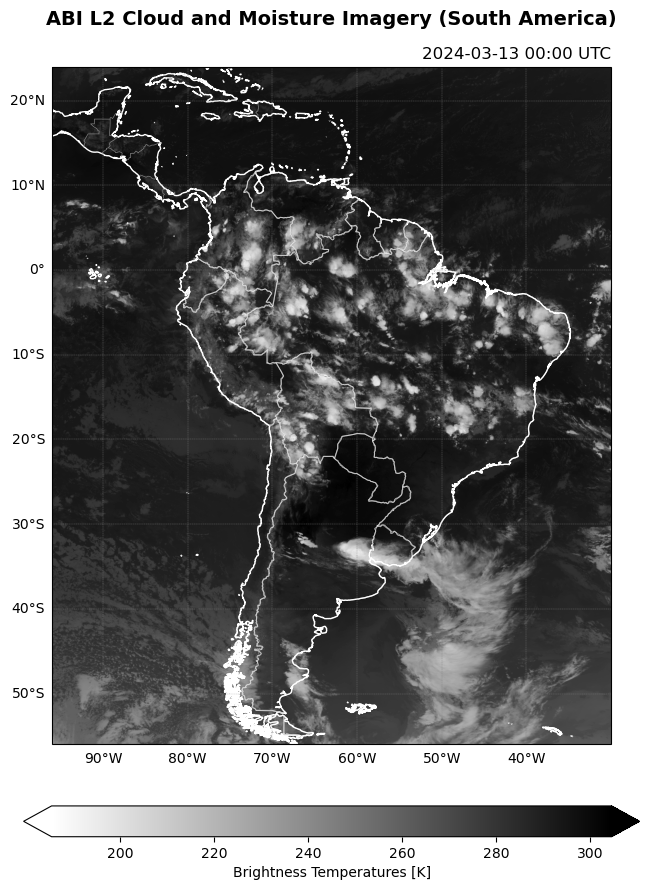

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs_latlon_proj})

ax.add_geometries(shp_geoms, ccrs_latlon_proj, ec='w', facecolor='none', lw=0.8, zorder=5, alpha=0.4)
ax.set_title(f"{title_prod} ({crop_scene_name})", loc='center', y=1.05, fontsize=14, fontweight='bold')
ax.set_title(f"{datetime_fmt.strftime('%Y-%m-%d %H:%M')} UTC", loc='right', fontsize=12)

img = ax.imshow(crop_abi_data, origin='upper', extent=img_extent, cmap='gray_r')

ax.coastlines(resolution='10m', 
              color='white', 
              linewidth=1)

ax.add_feature(cartopy.feature.BORDERS, 
               edgecolor='gray', 
               linewidth=0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  color='gray', 
                  alpha=1.0, 
                  linestyle='--', 
                  linewidth=0.25, 
                  xlocs=np.arange(-180, 180, 10), 
                  ylocs=np.arange(-90, 90, 10), 
                  draw_labels=True)

gl.top_labels = False
gl.right_labels = False

plt.colorbar(img, label='Brightness Temperatures [K]', 
             extend='both', orientation='horizontal', 
             pad=0.08, fraction=0.04)
plt.savefig(f"{out_path}/{crop_scene_name.replace(' ', '_')}_{title_prod.replace(' ', '_')}_{datetime}.png",
           transparent=False, bbox_inches='tight', pad_inches=0.1)


## Customizing color bar

In [26]:
def loadCPT(path):

    try:
        f = open(path)
    except:
        print ("File ", path, "not found")
        return None

    lines = f.readlines()

    f.close()

    x = np.array([])
    r = np.array([])
    g = np.array([])
    b = np.array([])

    colorModel = 'RGB'

    for l in lines:
        ls = l.split()
        if l[0] == '#':
            if ls[-1] == 'HSV':
                colorModel = 'HSV'
                continue
            else:
                continue
        if ls[0] == 'B' or ls[0] == 'F' or ls[0] == 'N':
            pass
        else:
            x=np.append(x,float(ls[0]))
            r=np.append(r,float(ls[1]))
            g=np.append(g,float(ls[2]))
            b=np.append(b,float(ls[3]))
            xtemp = float(ls[4])
            rtemp = float(ls[5])
            gtemp = float(ls[6])
            btemp = float(ls[7])

        x=np.append(x,xtemp)
        r=np.append(r,rtemp)
        g=np.append(g,gtemp)
        b=np.append(b,btemp)

    if colorModel == 'HSV':
        for i in range(r.shape[0]):
            rr, gg, bb = colorsys.hsv_to_rgb(r[i]/360.,g[i],b[i])
        r[i] = rr ; g[i] = gg ; b[i] = bb

    if colorModel == 'RGB':
        r = r/255.0
        g = g/255.0
        b = b/255.0

    xNorm = (x - x[0])/(x[-1] - x[0])

    red   = []
    blue  = []
    green = []

    for i in range(len(x)):
        red.append([xNorm[i],r[i],r[i]])
        green.append([xNorm[i],g[i],g[i]])
        blue.append([xNorm[i],b[i],b[i]])

    colorDict = {'red': red, 'green': green, 'blue': blue}

    return colorDict

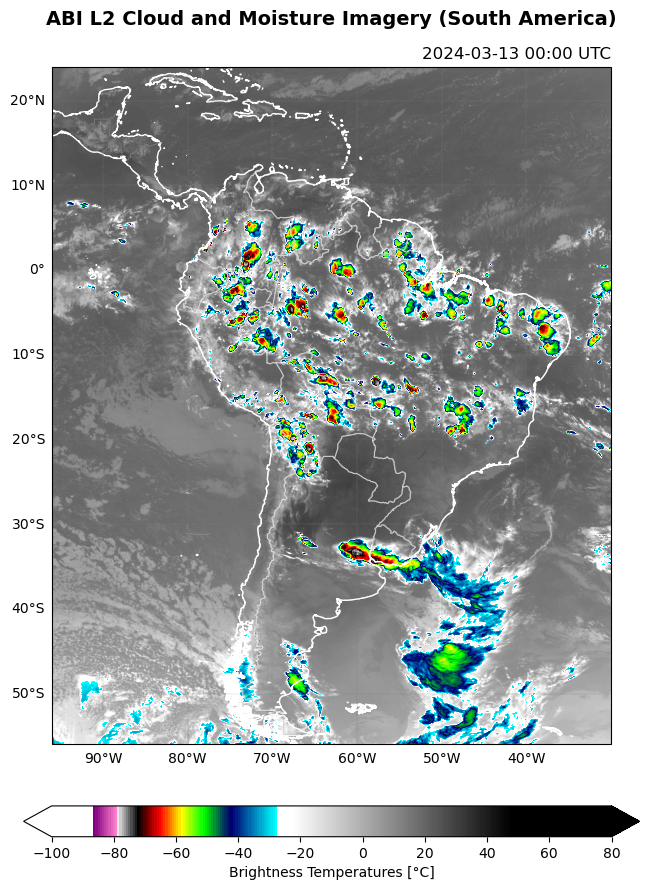

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs_latlon_proj})

custom_cmap = mpl.cm.colors.LinearSegmentedColormap('cpt', loadCPT(cpt_fn))
vmin, vmax = -100, 80


ax.add_geometries(shp_geoms, ccrs_latlon_proj, ec='w', facecolor='none', lw=0.8, zorder=5, alpha=0.4)
ax.set_title(f"{title_prod} ({crop_scene_name})", loc='center', y=1.05, fontsize=14, fontweight='bold')
ax.set_title(f"{datetime_fmt.strftime('%Y-%m-%d %H:%M')} UTC", loc='right', fontsize=12)

img = ax.imshow(crop_abi_data-273.15, origin='upper', extent=img_extent, vmin=vmin, vmax=vmax, cmap=custom_cmap)

ax.coastlines(resolution='10m', 
              color='white', 
              linewidth=1)

ax.add_feature(cartopy.feature.BORDERS, 
               edgecolor='gray', 
               linewidth=0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  color='gray', 
                  alpha=1.0, 
                  linestyle='--', 
                  linewidth=0.25, 
                  xlocs=np.arange(-180, 180, 10), 
                  ylocs=np.arange(-90, 90, 10), 
                  draw_labels=True)

gl.top_labels = False
gl.right_labels = False

plt.colorbar(img, label='Brightness Temperatures [°C]', 
             extend='both', orientation='horizontal', 
             pad=0.08, fraction=0.04)
plt.savefig(f"{out_path}/Custom_Colorbar_{crop_scene_name.replace(' ', '_')}_{title_prod.replace(' ', '_')}_{datetime}.png",
           transparent=False, bbox_inches='tight', pad_inches=0.1)


## GLM and ABI

In [28]:
glm_ds = xr.open_dataset(glm_fn)
event_lon = glm_ds['event_lon'].values
event_lat = glm_ds['event_lat'].values

group_lon = glm_ds['group_lon'].values
group_lat = glm_ds['group_lat'].values

flash_lon = glm_ds['flash_lon'].values
flash_lat = glm_ds['flash_lat'].values

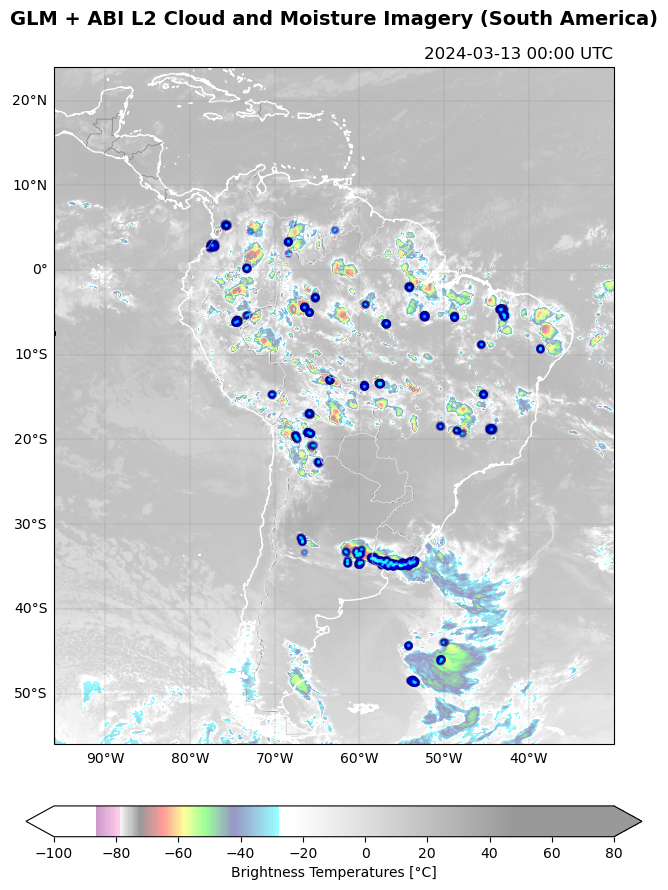

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs_latlon_proj})

custom_cmap = mpl.cm.colors.LinearSegmentedColormap('cpt', loadCPT(cpt_fn))
vmin, vmax = -100, 80


ax.add_geometries(shp_geoms, ccrs_latlon_proj, ec='w', facecolor='none', lw=0.8, zorder=5, alpha=0.4)
ax.set_title(f"GLM + {title_prod} ({crop_scene_name})", loc='center', y=1.05, fontsize=14, fontweight='bold')
ax.set_title(f"{datetime_fmt.strftime('%Y-%m-%d %H:%M')} UTC", loc='right', fontsize=12)

img = ax.imshow(crop_abi_data-273.15, origin='upper', extent=img_extent, vmin=vmin, vmax=vmax, cmap=custom_cmap, alpha=0.4)
ax.set_extent(img_extent, crs=ccrs_latlon_proj)
ax.plot(event_lon, event_lat, '.', color='darkblue', markersize=10, alpha=0.05, transform=ccrs.PlateCarree(), label='Events')
ax.plot(group_lon, group_lat, '.', color='blue', markersize=5, alpha=0.1, transform=ccrs.PlateCarree(), label='Groups')
ax.plot(flash_lon, flash_lat, '.', color='cyan', markersize=2.5, alpha=0.5, transform=ccrs.PlateCarree(), label='Flashes')

ax.coastlines(resolution='10m', 
              color='white', 
              linewidth=1)

ax.add_feature(cartopy.feature.BORDERS, 
               edgecolor='gray', 
               linewidth=0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  color='gray', 
                  alpha=1.0, 
                  linestyle='--', 
                  linewidth=0.25, 
                  xlocs=np.arange(-180, 180, 10), 
                  ylocs=np.arange(-90, 90, 10), 
                  draw_labels=True)

gl.top_labels = False
gl.right_labels = False

plt.colorbar(img, label='Brightness Temperatures [°C]', 
             extend='both', orientation='horizontal', 
             pad=0.08, fraction=0.04)
plt.savefig(f"{out_path}/GLM_ABI_{crop_scene_name.replace(' ', '_')}_{title_prod.replace(' ', '_')}_{datetime}.png",
           transparent=False, bbox_inches='tight', pad_inches=0.1)


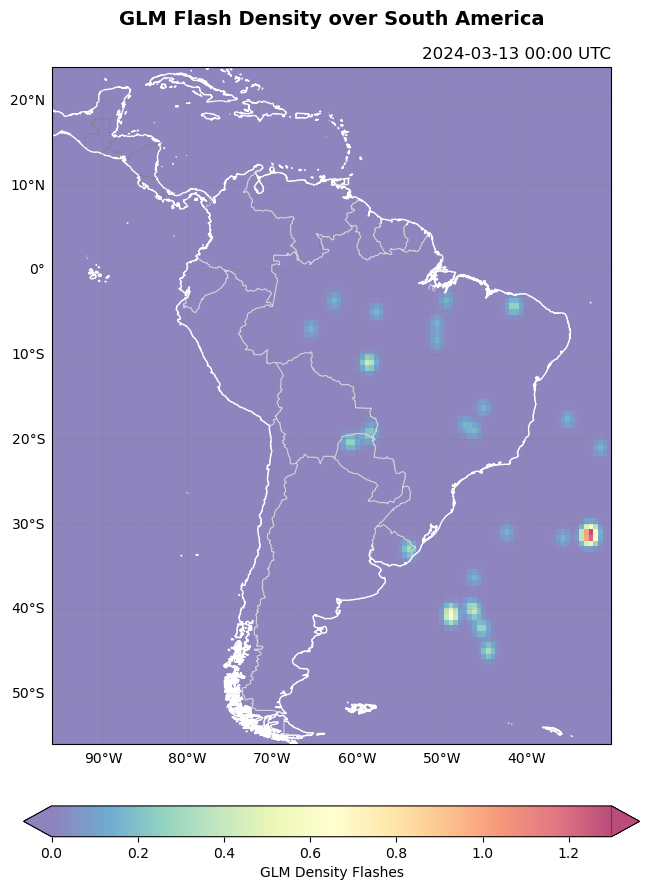

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs_latlon_proj})

ax.add_geometries(shp_geoms, ccrs_latlon_proj, ec='w', facecolor='none', lw=0.8, zorder=5, alpha=0.4)
ax.set_title(f"GLM Flash Density over {crop_scene_name}", loc='center', y=1.05, fontsize=14, fontweight='bold')
ax.set_title(f"{datetime_fmt.strftime('%Y-%m-%d %H:%M')} UTC", loc='right', fontsize=12)

flashes = np.vstack((flash_lon, flash_lat)).T
flashes = flashes[(flashes[:,0] >= lon_min) & (flashes[:,0] <= lon_max)]
flashes = flashes[(flashes[:,1] >= lat_min) & (flashes[:,1] <= lat_max)]

heatmap, x, y = np.histogram2d(flashes[:, 0], flashes[:, 1], bins=(120, 120), 
                               range=[(lon_min, lon_max), (lat_min, lat_max)])
flash_density = gaussian_filter(heatmap, 1)

img = ax.imshow(flash_density.T, origin="lower", cmap="Spectral_r", interpolation="nearest", 
                extent=img_extent, alpha=0.7)
ax.set_extent(img_extent, crs=ccrs_latlon_proj)

ax.coastlines(resolution='10m', 
              color='white', 
              linewidth=1)

ax.add_feature(cartopy.feature.BORDERS, 
               edgecolor='gray', 
               linewidth=0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  color='gray', 
                  alpha=1.0, 
                  linestyle='--', 
                  linewidth=0.25, 
                  xlocs=np.arange(-180, 180, 10), 
                  ylocs=np.arange(-90, 90, 10), 
                  draw_labels=True)

gl.top_labels = False
gl.right_labels = False

plt.colorbar(img, label='GLM Density Flashes', 
             extend='both', orientation='horizontal', 
             pad=0.08, fraction=0.04)
plt.savefig(f"{out_path}/GLM_Density_{datetime}.png",
           transparent=False, bbox_inches='tight', pad_inches=0.1)


## References
<hr />

- [1] - https://www.goes-r.gov

- [2] - https://geonetcast.wordpress.com/gnc-a-product-manipulation-tutorials/

- [3] - https://registry.opendata.aws/noaa-goes/